# Deep Learning project AIS - 2024

The project aims to improve the performance of a pre-trained architecture for image classification at Test Time (**TTA**), assuming that only one test input $\mathbf{x}_i$ is available (TTIA), the adaptation is made "on-the-fly" without any assumption on the training procedure or model architecture.

The objective is to robustificate the model alleviating degradations in performance due to input perturbations (e.g. noise, lighting changes, corruptions) or distribution shifts which normally occur in real-world applications, via adaptation.

Nevertheless, the implemented methods can be used to improve the performance at test-time of a pre-trained model without assuming explicit corruptions or distribution shifts, by adapting the model to each test sample $\mathbf{x}_i$ in a transductive learning manner.

*Note:*

Improving performance at test time, handling distribution shifts or known input perturbations are conceptually different topics, assuming the source of error could help produce better ad hoc methods. In scenarios when the source of error is not clearly identifiable, general methods can be useful.

### Dependencies

In [ ]:
# Global
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
import random
import copy
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import os
# Models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
# Datasets
from google.colab import drive

# MEMO - Marginal Entropy Minimization with One test point

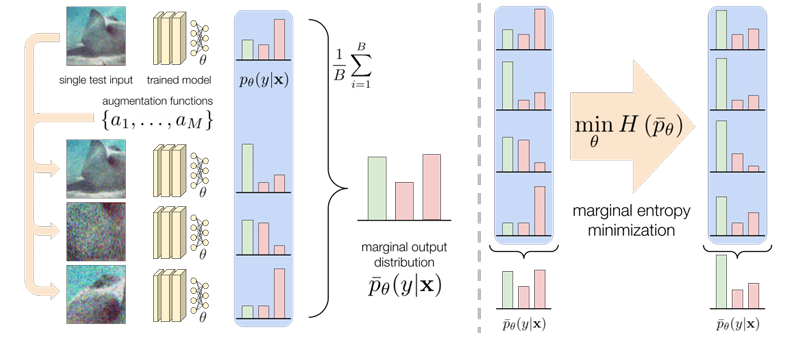

As starting point I have reimplemented **MEMO** as described in the original paper [Zhang et al. (2021)](https://arxiv.org/abs/2110.09506) with the addiction of the confidence selection strategy proposed in [Shu et al. (2022)](https://arxiv.org/abs/2209.07511).

When a test input $\mathbf{x}_i \in \mathcal{X}$ is presented for inference to a model $\mathcal{f}(\mathbf{x},\theta)$, with pre-trained parameters $\theta$, which outputs probabilities $\mathcal{p}(y|\mathbf{x},\theta)$ for classes $y \in \mathcal{Y}$, a set of augmentations $\mathcal{B}=\{\mathcal{b}_1,\dots,\mathcal{b}_N\}$ are sampled from a pre-defined set of augmentation functions $\mathcal{A}=\{\mathcal{a}_1,\dots,\mathcal{a}_M\}$.

The first step to predict the class $\hat{y}$ of input $\mathbf{x}_i$ is to apply the model to its sampled augmented versions $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$, then we can obtain the marginal distribution over the uniform distribution of augmentations $\mathcal{U}(\mathcal{A})$ as follows:

$$
\mathcal{p}_{m}(y|\mathbf{x}_i,\theta) = \mathbb{E}_{\mathcal{U}(\mathcal{A})}\left[\mathcal{p}(y|\mathcal{a}(\mathbf{x}_i),\theta)\right]
\approx \frac{1}{\rho N} \sum_{j=1}^N \mathcal{1}[\mathcal{H}(\mathcal{p}_{j}) \leq \tau] \mathcal{p}_{j}(y|\mathcal{b}_j(\mathbf{x}_i),\theta)
$$

where the indicator function $\mathcal{1}[\bullet]$ filters out noisy augmented images by selecting only images under the $\rho$-percentile($\leq\tau$) from the distribution generated by their entropy value $\mathcal{H}(\mathcal{p}_{j})$ (from low to high), that in this case is utilized as measure of confidence in the prediction (low entropy translates to high confidence).

Then model parameters $\theta$ are updated via one step of gradient based optimization (e.g. SGD, Adam) minimizing the entropy of its marginal distribution over augmentations (defined above):

$$
\mathcal{l_{me}}(\mathbf{x}_i,\theta) = \mathcal{H}(\mathcal{p}_{m}(\bullet|\mathbf{x}_i,\theta)) = - \sum_{y \in \mathcal{Y}}\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)\log{\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)}
$$

and the new parameters $\theta'$ are used to predict $\hat{y}$ from the original input $\mathbf{x}_i$ as usual:

$$
\hat{y} = \underset{y \in \mathcal{Y}}{\operatorname{argmax}} \mathcal{p}_{i}(y|\mathbf{x}_i,\theta')
$$

Finally, whenever a new test input is presented for inference the weights of the model $\theta'$  are resetted to the orginal pre-trained ones $\theta$. This process aims to ensure that:

- the predictions of the model $\mathcal{f}(\mathbf{x}_i,\theta')$ should be invariant to augumentations $\mathcal{a}(\mathbf{x}_i)$
- the model $\mathcal{f}(\mathbf{x}_i,\theta')$ should be confident in its own prediction, even for augmented versions of the input.

In [ ]:
## -- MEMO inference --

# Inference via MEMO
def MEMO_inference(model, x, aug_x, conf_tresh, optimizer, device):

    # Setup model
    model.eval()
    model.to(device)
    # Sanity check
    optimizer.zero_grad()

    # Apply the pre-trained model to the sampled augmentations of input x
    # (N, c, H, W) -> (N, |Y|)
    y_aug = model(aug_x)
    # Compute Log Normalized probabilities by softmax :- log(p(y|x))
    # (N, |Y|) -> (N, |Y|)
    y_log_prob = y_aug.log_softmax(dim=1)
    # Filter samples by confidence in the prediction
    # (N, |Y|) -> (conf_N, |Y|)
    filt_idxs = filter_samples_by_confidence(y_log_prob, conf_tresh)
    y_log_prob = y_log_prob[filt_idxs,:]

    # Gradient descend step to minimze the entropy of the marginal distribution (l_me)
    # (conf_N, |Y|) -> (1)
    loss = marginal_entropy_loss(y_log_prob)
    # Backprop
    loss.backward()
    # Update parameters
    optimizer.step()

    # Inference from updated model
    # (1, c, H, W) -> (1, |Y|)
    with torch.no_grad():
        output = model(x.unsqueeze(0)).log_softmax(dim=1)

    return output

# Filter samples by entropy tresholding, via percentille of discrete distribution
# NOTE! - Requires Log space probabilities
# (N, |Y|) -> (conf_N, |Y|)
def filter_samples_by_confidence(y_log_prob, conf_tresh):

    # Compute entropy for each augmented sample
    # (N, |Y|) -> (N)
    samples_entropy = -1 * torch.sum(y_log_prob * torch.exp(y_log_prob), dim=1)
    # Round percentile
    rounded_conf_tresh = int(y_log_prob.size()[0] * conf_tresh)
    # Filter samples by entropy tresholding
    # (N, |Y|) -> (rounded_conf_tresh, |Y|)
    _, idxs = torch.sort(samples_entropy, dim=0, descending=False, stable=True)
    filt_idxs = idxs[0:rounded_conf_tresh]

    return filt_idxs

# Compute the entropy of marginal distrubution over a set of samples
# NOTE! - Requires Log space probabilities
# (N, |Y|) -> (1)
def marginal_entropy_loss(y_log_prob):

    # Marginal probability in Log space
    # (N, |Y|) -> (|Y|)
    marg_y_log_prob = marginal_log_probability(y_log_prob)
    # Marginal entropy
    # (|Y|) -> (1)
    entropy = -1 * torch.sum(marg_y_log_prob * torch.exp(marg_y_log_prob))

    return entropy

# Compute marginal probability in Log space
# NOTE! - Requires Log space probabilities
# (N, |Y|) -> (|Y|)
def marginal_log_probability(y_log_prob):

    # Marginal probabilities :- 1/N * sum(p(y|x))
    # Mean in Log space :- log(1) - log(N) + log(sum(p(y|x))),
    # where :- log(sum(p(y|x))) = log(sum(exp(log(p(y|x)))))
    # (N, |Y|) -> (|Y|)
    N = torch.tensor(y_log_prob.size()[0])
    marg_y_log_prob = -1 * (torch.log(N)) + torch.logsumexp(y_log_prob, dim=0)

    return marg_y_log_prob

## BN statistics adaptation

In the original paper, whenever the backbone network was using Batch Normalization (BN) the authors additionally used this technique from [Schneider et al. (2020)](https://arxiv.org/abs/2006.16971).

This simple technique adapts the BN statistics "on-the-fly" (**NA**) using the following update:

$$
\mathbf{\mathcal{v}} = \frac{N}{N+1} \mathbf{\mathcal{v}}_{train} + \frac{1}{N+1} \mathbf{\mathcal{v}}_{test}
$$

where $\mathbf{\mathcal{v}}=[\mathbf{\mu},\mathbf{\sigma}^2]$ are the BN statistics. The former $\mathbf{\mathcal{v}}_{train}$ were collected during training, while the latter $\mathbf{\mathcal{v}}_{test}$ are the ones generated by evaluating the batch of augmented versions of the test input $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$.

Adapt BN statistics it is a known technique to mitigate the effect of distribution shifts.

### MEMO BN adaptation

Because in MEMO we collect for free (during the 1st forward pass) statistics from the full batch of augmentations $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$ I decided to implement two versions of adaptation for the 2nd forward pass (the one used for infer $\hat{y}$):

- **Single** - $\mathbf{\mathcal{v}}_{test}$ are computed "on-the-fly" from the single test image $\mathbf{x}_i$

- **Batch** - $\mathbf{\mathcal{v}}_{test}$ are kept from augmented batch $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$ (1st forward pass)

In cases where distribution shifts are more severe the latter should improve performances [see Results].

In [ ]:
## -- Norm Adaptation --

# MEMO version of Batch Norm Adaptive computation
# NOTE! Inference ONLY, i.e. works for model.eval() NOT for model.train()
#       If keep_test_running is False, behave as simple norm adaptation
class MEMOAdaptiveBatchNorm(nn.Module):

    def __init__(self, pre_bn_layer, prior_N, keep_test_running):
        super().__init__()
        # Previous BN layer from pre-trained model
        self.pre_bn_layer = pre_bn_layer
        # Norm Adaptation hyperparameters
        self.prior_N = prior_N
        # Use batch stats 1st forward pass (v_test) for 2nd forward pass
        self.keep_test_running = keep_test_running
        self.test_batch_mean = None
        self.test_batch_var = None

    # Adapt normalization statistics
    def forward(self, input):

        # Sanity check model.eval only
        assert(not self.pre_bn_layer.training)
        # Torch required assertion
        self.pre_bn_layer._check_input_dim(input)

        # 1st forward pass (test batch mean and var None)
        if self.test_batch_mean is None and self.test_batch_var is None:

            # Compute test batch normalization statistics
            # (N, c, H, W) -> (c)
            curr_mean, curr_var = self.compute_norm_stats(input)
            # Save 1st forward batch stats
            if self.keep_test_running:
              self.test_batch_mean = curr_mean
              self.test_batch_var = curr_var

        # 2nd forward pass
        else:

            # If batch statistics are used for both 1st and 2nd forward pass
            if self.keep_test_running:
              curr_mean = self.test_batch_mean
              curr_var = self.test_batch_var
            # Otherwise compute norm stats from current input
            else:
              # (N, c, H, W) -> (c)
              curr_mean, curr_var = self.compute_norm_stats(input)

            # Consistency reset
            self.test_batch_mean = None
            self.test_batch_var = None

        # Modify statistics via linear combination of v_train and v_test
        # a * v_train + (1-a) * v_test
        alpha = self.prior_N / (self.prior_N + 1)
        running_mean = alpha * self.pre_bn_layer.running_mean + (1 - alpha) * curr_mean
        running_var = alpha * self.pre_bn_layer.running_var + (1 - alpha) * curr_var

        # Return adapted normalized statistics (layer output)
        # (N, c, H, W)
        return nn.functional.batch_norm(input, running_mean, running_var, self.pre_bn_layer.weight,
                                        self.pre_bn_layer.bias, False, 0, self.pre_bn_layer.eps)

    # HELPERS

    # Compute normalization statistics from a given batch/instance
    def compute_norm_stats(self, input):

        # Compute current batch statistics v_test[mean,var]
        N, c, H, W = input.shape
        # (N, c, H, W) -> (c, N, H, W)
        t_input = input.transpose(0, 1).detach()
        # Flatten out hidden units h_i per channel (c, h_i),
        # (c, N, H, W) -> (c, N*H*W)
        collapsed_input = t_input.contiguous().view(c, N*H*W)
        # Compute statistics (mean,var) over the channels
        # (c, N*H*W) -> (c)
        mean = collapsed_input.mean(dim=1)
        var = collapsed_input.var(dim=1, unbiased=False)

        return mean, var

In [ ]:
# Change Normalization Layers (e.g. BatchNorm2d) behaviour in the model
# Allows to use MEMO batch statistics of 1st forward pass as stats for 2nd pass
class MEMOAdaptiveBatchNormModel(nn.Module):
    def __init__(self, model, prior_N, keep_test_running, copy_model=True):
        super().__init__()
        # Pre-trained model
        self.model = copy.deepcopy(model) if copy_model else model
        # Norm Adaptation
        self.prior_N = prior_N
        # Use batch stats 1st forward pass (v_test) for 2nd forward pass
        self.keep_test_running = keep_test_running
        # Override _BatchNorm Layers
        self.adapt_Batch_Norm_layers()

    def forward(self, x):
        return self.model(x)

    # HELPERS

    # Modify behaviour of _BatchNorm layers of the model with MEMOAdaptiveBN custom one
    def adapt_Batch_Norm_layers(self):

        # Find BN modules (layers)
        bn_modules = self.find_bn_modules(self.model)

        # Iterate over found BN modules
        for parent, name, new_module in bn_modules:
            # Substitute BN module with MEMOAdaptiveBN
            setattr(parent, name, new_module)

  # Tree-like search of Batch Norm modules in the model
    def find_bn_modules(self, parent):

        bn_modules = []
        # Iterate over module's childrens
        for name, child_module in parent.named_children():

            # If child module is BN layer
            if isinstance(child_module, torch.nn.modules.batchnorm._BatchNorm):
                # Compose new MEMOAdaptiveBN and add to the list of modules to substitute
                new_module = MEMOAdaptiveBatchNorm(child_module, self.prior_N, self.keep_test_running)
                bn_modules.append((parent, name, new_module))
            # Otherwise search recursively
            else:
                bn_modules.extend(self.find_bn_modules(child_module))

        return bn_modules

## Reasoning on MEMO

MEMO follows TENT [Wang et al. (2021)](https://arxiv.org/abs/2006.10726) and BN adaptations [Schneider et al. (2020)](https://arxiv.org/abs/2006.16971) works.

TENT empirically showed that optimizing BN transformation parameters (i.e. $\gamma$, $\beta$) via entropy minimization of batch average predictions $\mathcal{l_{me}}(\bullet)$ reduces test error under distribution shifts, these choice is mainly motivated by correlation found empirically between entropy of predictions and test error in datasets of corrupted images.

Differently, MEMO optimizes the whole model parameters $\theta$ (optimizing for a single instance does not have to account for model degradation). In addiction, MEMO runs BN statistics as a linear combination of train/test batch statistics $(\mathbf{\mathcal{v}}_{train},\mathbf{\mathcal{v}}_{test})$ , while TENT fully uses fully test statistics $\mathbf{\mathcal{v}}_{test}$. Notice that being able to optimize the whole model parameters $\theta$ gives MEMO more expressive power, allowing the model to reuse all its representational capacity to learn new features optimized for a single test instance $\mathbf{x}_i$.

Looking only at papers experiments there are no clear positive results on entropy minimization using only train statistics shown in the papers, these results suggest that running entropy minimization on test batch statistics is a main component of adaptation, even though further ablation studies should be conducted. - [see Results]

### Entropy minimization

Entropy minimization is justified by [Grandvalet and Bengio (2004)](https://proceedings.neurips.cc/paper_files/paper/2004/file/96f2b50b5d3613adf9c27049b2a888c7-Paper.pdf) as a form of regularization to improve semi-supervised learning techniques. Assuming that class boundaries live in low-density region of the data space (so-called cluster assumption) applying this form of regularization diminuishes entropy for unlabeled samples moving boundaries away from regions populated by them.

Notice that the deep learning framework is more sophisticated than the shallow one in which the entropy minimization regularization has been proposed and that entropy minimization is applied at test time, not at training time. Samples with high entropy in deep learning are usually associated with low confidence predictions, follow-up work [Shu et al. (2022)](https://arxiv.org/abs/2209.07511) empirically showed that removing low confidence predictions improves MEMO.

Roughly, errors from a pre-trained model can be conceptually characterized in: (i) the feature extractor outputs representations in completely wrong areas of the feature space, and (ii) class boundaries on the last hidden representations are wrongly defined.

Following the original ideas, BN adaptation should tackle (i) meanwhile entropy minimzation handles (ii), but empirically it seems that the learning signal of entropy minimization helps reducing (i) too, as shown by TENT.

Based on these studies, it is not clear how entropy minimization should optimize the feature extractor to collectively improve performances on a test batch. It could be that all (or a majority) test samples require the same modifications to the feature extractor to minimize the entropy, but more work should be done to understand the effect of entropy regularization on hidden representations.

From an intuitive point of view, if class boundaries in the last hidden representations remain fixed (as for TENT) optimizing the feature extractor should push representations of the test samples from low-density regions towards class prototypes. In case of distribution shift, this seems a plausible assumption because training on source distribution should have placed class prototypes w.r.t. regions with high density of features obtained from class training samples of source distribution. Even in cases where no distribution shifts are explicitly assumed, it is possible that errors are the results of outliers in the training data, consequently the model may did not have optimized well the representations of such inputs. If the model has learned completely wrong representations for all augmented samples $\mathcal{a}(\mathbf{x}_i)$, I will argue that little work could be done because the model does not have enough information encoded in its parameters $\theta$ to fix the error.

Notice that following the problem settings and its related assumptions model features/predictions are the only form of information available to improve performances.

### Multi-Augmentation inference

MEMO can be viewed as an extension of TENT in which, in order to apply TENT to a single test instance $\mathbf{x}_i$, it produces a batch of augmentations of the istance $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$.

Predicting class $\hat{y}$ by averaging the predictions of different augmentations (MA) of the test sample $\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)$ is a standard inference technique [Krizhevsky et al. (2012)](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and usually improves model accuracy [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556).

If a test input prediction $\mathcal{p}_{i}(y|\mathbf{x}_i,\theta)$ is wrongly approximated by the model, averaging the results over semantically identical test points in the input space $\mathcal{p}_{j}(y|\mathcal{b}_j(\mathbf{x}_i),\theta)$ should lower the variance in the prediction. Consequently, composing the batch as augmentations of the same test sample seems to be a good idea, it gives accurate predictions by also producing for free normalization statistics for the BN adaption modules.

Because in MEMO we have the possibility to predict via marginal distribution over augmentation $\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)$ without increasing the computational cost I decided to add **MA** as baseline too.

Remember that minimize the entropy over any probability distribution $\mathcal{p}(y)$ push the value in the domain $\mathcal{Y}$ (classes in our case) with highest probability towards even greater values and so predicting via $\hat{y} = \underset{y \in \mathcal{Y}}{\operatorname{argmax}} \mathcal{p}(y)$ shouldn't change the prediction. The following fact applies for both $\mathcal{p}_{i}(y|\mathbf{x}_i,\theta)$ and $\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)$, so we should not expect any changes in the prediction applying MA before or after entropy minimization step if we use again the full batch of agumented images $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$ to predict $\hat{y}$ (precisely, SGD could anyway change the predictions due to its approximate update on $\theta$).

However the comulative information in $\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)$ could point a direction in the parameters space $\theta$ where $\mathcal{p}_{i}(y|\mathbf{x}_i,\theta)$ changes, due to results in [Zhang et al. (2021)](https://arxiv.org/abs/2110.09506) I expect MA to be very strong baseline in datasets without explicit shift (e.g. ImageNet-A) while fell shortly w.r.t MEMO where explicit shift are present (e.g ImageNet-C).

## Improving MEMO

### Motivations

MA demonstrate in conducted experiments to be a very strong baseline in datasets where no explicit shift is assumed (our cases) but to not have the same performances that MEMO has when poor information is encoded in the batch of augmented images [see Results] or when some explicit shits are incorporated in the datasets as shown in the reference paper.

Motivated by these results I tried to merge MA inference in the 2nd forward pass of MEMO to boost performances and robustness in predictions under an increased amount of scenarios, as expressed by the desiderata.

From now on I will refer to my proposed modification of MEMO as **RMEMO** (Robust MEMO).

*Note:*

Remember that assuming something about the original $\mathcal{p}(\mathbf{x})$ under which the model is trained is also a strong assumption and could lead to choose augmentations where the model predictions encode more accurate information w.r.t. to others (for example rotations could work for models trained on natural images but does not translate mandatorily for medical images models).  

My objective will be to make RMEMO robust towards scenario which no information is known a priori.

### Research question

Recall that predicting via $\mathcal{p}_{m}(y|\mathbf{x}_i,\theta)$ so apply MA on the same test samples $\{\mathbf{x}_j\}$ before or after entropy minimization should not change the final prediction of $\hat{y}$, so the question that arise is the following:

- "Which image/s should we consider to use for MA inference in the final forward pass?"

Notice also that MEMO naively gives its final prediction using the original test sample $\mathbf{x}_i$ so via $\mathcal{p}_{i}(y|\mathbf{x}_i,\theta)$, because augmented samples are semantically equivalent we can in principle use any of them to predict $\hat{y}$ even without applying MA - [see Results].

## RMEMO

The overall schema for RMEMO is almost unchanged from MEMO and it is the following:

1. Apply the pretrained model $\mathcal{f}(\mathbf{x},\theta)$ to the sampled set of augmented images $\{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$, this pass serve as a search to collect information to select the most relevant images.

2. Update the model parameters $\theta$ by entropy minimization, obtaining $\theta'$.

3. Use MA on the new optimized model $\mathcal{f}(\mathbf{x},\theta')$ over the selected images to predict $\hat{y}$, giving a more robust prediction of $\hat{y}$.

More formally we want to select a subset $\mathcal{C} = \{\mathcal{c}_1(\mathbf{x}_i),\dots,\mathcal{c}_K(\mathbf{x}_i)\} \subseteq \{\mathcal{b}_1(\mathbf{x}_i),\dots,\mathcal{b}_N(\mathbf{x}_i)\}$ to predict as follow:


$$
\hat{y} = \underset{y \in \mathcal{Y}}{\operatorname{argmax}} \mathcal{p}_{s}(y|\mathbf{x}_i,\theta'), \quad \mathcal{p}_{s}(y|\mathbf{x}_i,\theta') = \sum_{k=1}^{K} \mathcal{p}_{j}(y|\mathcal{c}_{k}(\mathbf{x}_i),\theta')
$$


where the reported inference is simply the classic MA inference over $\mathcal{C}$ and some critirion is utilized to get $\mathcal{C}$.

Based on the objective of entropy minimization and mainteining the filter by confidence in the prediction, I formulated three heuristics to experiment with to select the images in $\mathcal{C}$ for the final prediction.

### RMEMO (KL)

The first proposal is to take the top $K$ augmented images with lowest distance from the marginal distribution $\mathcal{p}_{m}(y|\mathbf{x}_i,\theta')$, as follows:

$$
\mathcal{C} = \{\mathcal{b}_j(\mathbf{x}_i) | D_{KL}\left[\mathcal{p}_{m} || \mathcal{p}_{j}\right] \leq \tau\}
$$

where $\tau$ is the $\rho$-percentile ($K/N$) threshold as expressed before and we use the KL divergence as metric to compute the distance between two probability distributions.

This heuristic should ensure a correct prediction if the model predictions already agree on average on the correct one and be close to predict the same $\hat{y}$ if we were inferring with MA, discarding possible outliers $\mathcal{p}_{j}(y|\mathcal{b}_j(\mathbf{x}_i))$ with high confidence. However if the average prediction have high entropy the selected samples may be ones with low confidence discarding the more important informations given by the model.

### RMEMO (TK)

Following [Shu et al. (2022)](https://arxiv.org/abs/2209.07511) this heuristic retain the top $K$ augmented images with higher confidence, formally:

$$
\mathcal{C} = \{\mathcal{b}_j(\mathbf{x}_i) | H(\mathcal{p}_{j}) \leq \tau\}
$$

using the entropy $H(\mathcal{p}_{j})$ as confidence metric as before.

Differently from KL, in this settings we always gather the most informative predictions according to the model knowledge (as long as we trust entropy as confidence metric) but the selected ones could be influenced by outliers.

The procedure is similar to MA with confidence selection filtering [see Ablations] but it infers from the optimezed model $\mathcal{f}(y|\mathbf{x}, \theta')$ insted that using the original one $\mathcal{f}(y|\mathbf{x}, \theta)$.

### RMEMO (SR)

As compromise between KL and TK, the last proposal is a simple score rank-base heuristic that promotes both closeness to marginal distribution and high confidence predictions, specifically it retains:

$$
\mathcal{C} = \{\mathcal{b}_j(\mathbf{x}_i) | r(D_{KL}\left[\mathcal{p}_{m} || \mathcal{p}_{j}\right])+r(H(\mathcal{p}_{j})) \leq \tau\}
$$

where $r(\bullet)$ returns the rank (index) in the sorted list defined by the critirion (from low to high).

The idea is to get the best of both worlds, so agreeness on marginal distribution and most informative predictions, possibly discarding confident outliers that live far in probability space from the average prediction.

### Considerations on Heuristics

Notice that in RMEMO the selection procedure follows the filtering of low confidence predictions for all heuristics. Because of that diminuishing the $\rho$-percentile towards $(K/N)$-percentile will progressively push the effect of KL selection towards SR and then the SR one towards TK (least confidence predictions will be filtered out before picking $\mathcal{C}$).

This means that by chosing different values of $\rho$ in the KL or SR settings we could obtain very different results, in anycase I expect SR to be more robust than KL.

Below you can have a look to an illustrative simplified scenario to graps a geometric intepretations of expected results from the proposed heuristics.

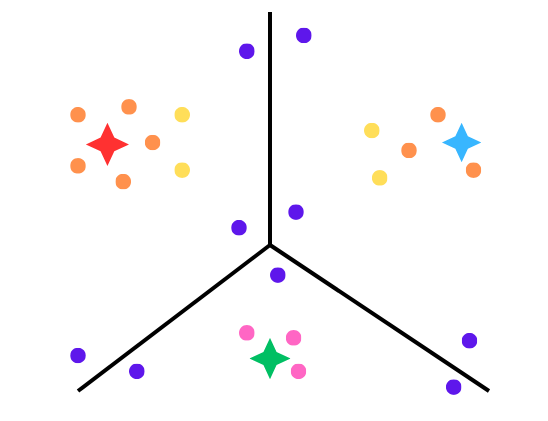

*Caption*:

A feature space with decision boundaries (*black lines*) splitting three classes (*red*, *blue*, *green*) with related class prototypes (*stars*). Samples (*points*) are first filtered out by confidence in the prediction (*purple*), then chosing a different heuristic will results in different inference sets $\mathcal{C}$.

KL will select points near to marginal distribution (*yellow*, *orange*) discarding outliers (*pink*) but with the risk to retain low confident ones (*yellow*), while TK will pick only confident ones (*pink*, *orange*) possibily including outliers (*pink*). Finally SR uses both confidence and agreeness informations to discard undesired points (*yellow*, *pink*) and ideally retain better informative points (*orange*).

## Biased RMEMO

By inferring the class from agumented samples $\mathcal{b}_{j}(\mathbf{x}_{i})$ instead that the original one we could ruin the original prediction if it was previously correct, especially under strong augmentations for a model that was not trained to be robust towards them.

In my opinion, it will be interesting to tackle the TTIA problem from a different perspective, instead of completely substituting the inputs to the model from $\mathbf{x}_i$ to $\mathcal{C}$ as in RMEMO or MA we can integrate the information originated from $\mathcal{C}$ to update the prediction from $\mathbf{x}_i$. Generally we generate the prediction in this way:

$$
\hat{y} = \underset{y \in \mathcal{Y}}{\operatorname{argmax}} \mathcal{g}(\mathcal{p}_i(y|\mathbf{x},\theta), \mathcal{p}_s(y|\mathbf{x},\theta))
$$

where $\mathcal{g}(\bullet,\bullet)$ is an aggregator function that merges the two probability distribution. To test this idea as starting point I simply decided to merge predictions via a weighted average:

$$
\hat{y} = \underset{y \in \mathcal{Y}}{\operatorname{argmax}} \textrm{bc} \mathcal{p}_i(y|\mathbf{x},\theta) * (1- \textrm{bc}) \mathcal{p}_s(y|\mathbf{x},\theta)
$$

in which $bc$ is a scalar bias coefficient that indicates how much we trust our model original prediction $\mathcal{p}_i(y|\mathbf{x},\theta)$.

We can introduce manually this costant as hyperparameter, maybe considering the different conditions under which the model will be utilized or as reasonable guess to simply put the original model accuracy avoiding to add another hyperparameter to tune.

*Note*:

To make a more fair comparison between Biased RMEMO and MEMO I decided to avoid to bias the augmentation procedure too, so put the identity augmentations $I(\bullet)$ with probability one in the set of sampled augmentations $\mathcal{B}$, in this way the model will be optimized only on the augmentations as done by [Zhang et al. (2021)](https://arxiv.org/abs/2110.09506) without including $\mathbf{x}_i$.

In [ ]:
## -- MA inference --

# Inference via marginalization over the distribution of augmented images
def multi_augmentation_inference(model, aug_x, conf_tresh, device):

    # Setup model
    model.eval()
    model.to(device)

    # Apply the model to the sampled augmentations of input x
    # (N, c, H, W) -> (N, |Y|)
    y_aug = model(aug_x)
    # Compute Log Normalized probabilities by softmax :- log(p(y|x))
    # (N, |Y|) -> (N, |Y|)
    y_log_prob = y_aug.log_softmax(dim=1)
    # Filter samples by confidence in the prediction
    # (N, |Y|) -> (conf_N, |Y|)
    filt_idxs = filter_samples_by_confidence(y_log_prob, conf_tresh)
    y_log_prob = y_log_prob[filt_idxs,:]
    # Marginal probabilities
    # (N, |Y|) -> (1, |Y|)
    marg_y_log_prob = marginal_log_probability(y_log_prob)
    output = torch.exp(marg_y_log_prob).unsqueeze(0)

    return output


## -- Biased inference --

# Biased inference by linear interpolation between x and aug_x predictions using bias_c coefficient
def biased_inference(model, x, aug_x, bias_c, device):

    # Setup model
    model.eval()
    model.to(device)

    # Apply the model to the original image + sampled augmentations of input x
    # (1, c, H, W), (N, c, H, W) -> (N+1, c, H, W)
    biased_aug_x = torch.cat((x.unsqueeze(0), aug_x), dim=0)
    # (N+1, c, H, W) -> (N+1, |Y|)
    y_aug = model(biased_aug_x)
    # Compute Log Normalized probabilities by softmax :- log(p(y|x))
    # (N+1, |Y|) -> (N+1, |Y|)
    y_log_prob = y_aug.log_softmax(dim=1)
    # Split prediction of original image from augmented images
    # (N+1, |Y|) -> (1, |Y|), (N, |Y|)
    id_y_log_prob, aug_y_log_prob = y_log_prob[0,:].unsqueeze(0), y_log_prob[1:,]
    # Marginal probabilities of augmentations
    # (N, |Y|) -> (1, |Y|)
    aug_marg_y_log_prob = marginal_log_probability(aug_y_log_prob).unsqueeze(0)
    # Linear interpolation between predictions
    # (1, |Y|) -> (1, |Y|)
    biased_marg_y_log_prob = bias_c * id_y_log_prob + (1 - bias_c) * aug_marg_y_log_prob
    output = torch.exp(biased_marg_y_log_prob)

    return output

In [ ]:
## -- RMEMO inference --

# Inference via RMEMO
def RMEMO_inference(model, x, aug_x, conf_tresh, heuristic, sel_K, bias_c, optimizer, device):

    # Setup model
    model.eval()
    model.to(device)
    # Sanity check
    optimizer.zero_grad()

    # Apply the pre-trained model to the sampled augmentations of input x
    # (N, c, H, W) -> (N, |Y|)
    y_aug = model(aug_x)
    # Compute Log Normalized probabilities by softmax :- log(p(y|x))
    # (N, |Y|) -> (N, |Y|)
    y_log_prob = y_aug.log_softmax(dim=1)
    # Filter samples by confidence in the prediction
    # (N, |Y|) -> (conf_N, |Y|)
    filt_idxs, topk_idxs = filter_samples_by_confidence_plus_tk(y_log_prob, conf_tresh, sel_K)
    y_log_prob = y_log_prob[filt_idxs,:]

    # Gradient descend step to minimze the entropy of the marginal distribution (l_me)
    # (conf_N, |Y|) -> (1)
    loss = marginal_entropy_loss(y_log_prob)
    # Backprop
    loss.backward()
    # Update parameters
    optimizer.step()

    # Select images for inference (C)
    if heuristic == 'KL':
        selected_imgs_idxs = get_kl_closer_imgs_idxs(y_log_prob, sel_K)
    elif heuristic == 'TK':
        selected_imgs_idxs = topk_idxs
    elif heuristic == 'SR':
        selected_imgs_idxs = get_sr_closer_imgs_idxs(y_log_prob, sel_K)
    else:
        raise NotImplementedError(f"Unknown Heuristic: {heuristic}")
    # (conf_N, c, H, W) -> (sel_K, c, H, W)
    selected_imgs = aug_x[selected_imgs_idxs,:,:,:]

    # Inference from updated model
    # (sel_K, c, H, W) -> (1, |Y|)
    with torch.no_grad():
        if bias_c:
            output = biased_inference(model, x, selected_imgs, bias_c, device)
        else:
            output = multi_augmentation_inference(model, selected_imgs, 1, device)

    return output


## -- Heuristics --

# Select images for final inference via KL heuristic
def get_kl_closer_imgs_idxs(y_log_prob, sel_K):

    # Compute marginal distribution (p_m) over the sampled augmentations
    # (N, |Y|) -> (1, |Y|)
    marg_y_log_prob = marginal_log_probability(y_log_prob).unsqueeze(0)
    N = torch.tensor(y_log_prob.size()[0])
    # (1, |Y|) -> (N, |Y|)
    rep_marg_y_log_prob = marg_y_log_prob.repeat(N, 1)

    # Compute KL divergence from each image to marginal distribution (p_m)
    # (N, |Y|) -> (N)
    kl_divs = torch.nn.functional.kl_div(y_log_prob, rep_marg_y_log_prob, reduction='none', log_target=True)
    kl_divs = kl_divs.sum(dim=1)

    # Get top K images idxs
    _, idxs = torch.sort(kl_divs, dim=0, descending=False, stable=True)
    idxs = idxs[0:sel_K]

    return idxs

# Select images for final inference via SR heuristic
def get_sr_closer_imgs_idxs(y_log_prob, sel_K):

    # Compute marginal distribution (p_m) over the sampled augmentations
    # (N, |Y|) -> (1, |Y|)
    marg_y_log_prob = marginal_log_probability(y_log_prob).unsqueeze(0)
    N = torch.tensor(y_log_prob.size()[0])
    # (1, |Y|) -> (N, |Y|)
    rep_marg_y_log_prob = marg_y_log_prob.repeat(N, 1)

    # Compute KL divergence for each image to marginal distribution (p_m)
    # (N, |Y|) -> (N)
    kl_divs = torch.nn.functional.kl_div(y_log_prob, rep_marg_y_log_prob, reduction='none', log_target=True)
    kl_divs = kl_divs.sum(dim=1)

    # Compute entropy for each augmented sample
    # (N, |Y|) -> (N)
    samples_entropy = -1 * torch.sum(y_log_prob * torch.exp(y_log_prob), dim=1)

    # Score ranking
    # (N) -> (N)
    _, kl_idxs = torch.sort(kl_divs, dim=0, descending=False, stable=True)
    _, ent_idxs = torch.sort(samples_entropy, dim=0, descending=False, stable=True)
    kl_idxs, ent_idxs = kl_idxs.tolist(), ent_idxs.tolist()
    scores = {i: kl_idxs.index(i)+ent_idxs.index(i) for i in range(0,N)}
    idxs = sorted(scores, key=scores.get)

    # Get Top K confident images idxs for inference
    idxs = idxs[0:sel_K]

    return idxs

# Filter samples by entropy tresholding, via percentille of discrete distribution
# Return also indexes of Top K samples
# NOTE! - Requires Log space probabilities
# (N, |Y|) -> (conf_N, |Y|)
def filter_samples_by_confidence_plus_tk(y_log_prob, conf_tresh, sel_K):

    # Compute entropy for each augmented sample
    # (N, |Y|) -> (N)
    samples_entropy = -1 * torch.sum(y_log_prob * torch.exp(y_log_prob), dim=1)
    # Round percentile
    rounded_conf_tresh = int(y_log_prob.size()[0] * conf_tresh)
    # Filter samples by entropy tresholding
    # (N, |Y|) -> (rounded_conf_tresh, |Y|)
    _, idxs = torch.sort(samples_entropy, dim=0, descending=False, stable=True)
    filt_idxs = idxs[0:rounded_conf_tresh]

    # Get Top K confident images idxs for inference
    topk_idxs = idxs[0:sel_K]

    return filt_idxs, topk_idxs

# Experiments

## Backbones

I tested MEMO on the following pre-trained architectures on ImageNet (from torchvision):

- **ResNet-50** (CNN) - [He et al. (2015)](https://arxiv.org/abs/1512.03385)

This is a very popular CNN model with the addiction of residual connections, allowing deeper model to be well optimized and do not degradate in performace w.r.t. shallower onces.

It stacks residual blocks built by convolutional layers of Conv2d + BN + ReLU 3 times (1st Conv2d 1x1, then 3x3 and finally 1x1 again) before adding the original signal through residual connections via element-wise addiction. In totat it has a 50 convolutional layers, the first one is composed by 7x7 filters without residual block.

When the image passes throught the network the feature maps are downsampled and the number of channels increase. Finally an average pooling followed by a fully connected layer + softmax output allow the network to output probabilities for each class.

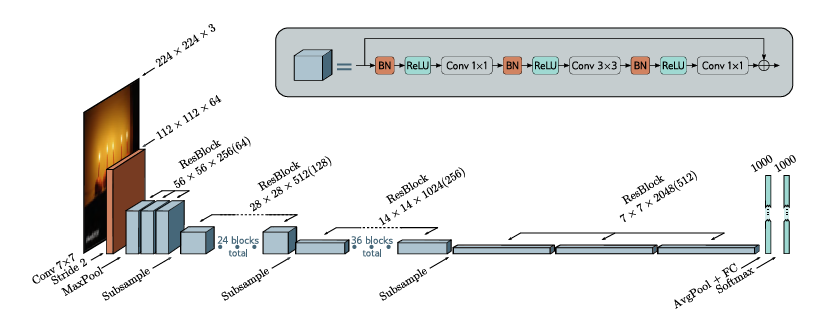

*Note*: This image represents deeper ResNet (200 Layers) and in convolutional layers the original order of Conv2d + BN + ReLU has been modified.

- **VIT-B/16** (Vision Transformer) - [Dosovitskiy et al. (2020)](https://arxiv.org/abs/2010.11929 )

One of the first transformer model used in computer vision, it requires less computational resources to be pre-trained w.r.t. CNNs models.

It uses the original transformer architecture, i.e. stack of transformer blocks composed by LN + MSA + LN + MLP (2 layers, GELU activation function) with residual connection, for a total of 12 blocks. Input patches are generated by linear projecting image patches (16x16) into patch embeddings, the patches are then added to positional embeddings and fed into the transformer. To classify the image, a learnable class embedding is added at the beginning of the sequence, the resulting representation will be passed trough a 1 layer MLP head + softmax to obtain class probabilities.

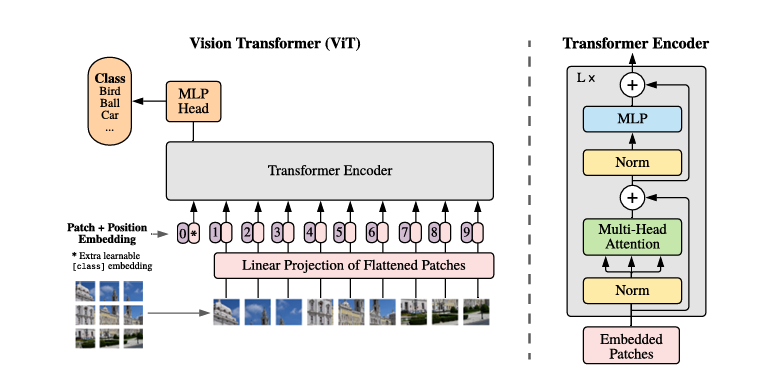

*Note*:

CNNs and Vision Transformers are two different architectures, even if VIT uses LN instead of BN experiments on VIT cannot be considered an ablation of BN adaptation for MEMO.

In [ ]:
## -- Pre-trained Backbones --

# Load ResNet-50 from torchvision
def load_ResNet50():

  weights = ResNet50_Weights.IMAGENET1K_V1
  preprocess = weights.transforms()
  return resnet50(weights=weights), preprocess

# Load VIT-B/16 from torchvision
def load_VITB16():

  weights = ViT_B_16_Weights.IMAGENET1K_V1
  preprocess = weights.transforms()
  return vit_b_16(weights=weights), preprocess

# Load models
model_resnet50, preprocess_resnet50 = load_ResNet50()
model_vit_b_16, preprocess_vit_b_16 = load_VITB16()

## Datasets

The two utilzed benchmark datasets are the following:

- **ImageNet-A** -  [Hendrycks et al. (2019)](https://arxiv.org/abs/1907.07174)

This dataset is composed by 7500 images of 200 ImageNet classes miss-classified by ResNet-50. Examples result very hard to classify also by other popular pre-trained models.

- **ImageNet-V2** - [Recht et al. (2019)](https://arxiv.org/abs/1902.10811)

Other 10000 images of 1000 ImageNet classes were collected mimicing the data collection procedure of the original ImageNet dataset to compose a new test set. Popular pre-trained models tested on these images drop in accuracy.

*Note:*

These datasets don't come with any assumption or explicit known type of input perturbations (e.g. corruptions), models find images from these datasets harder to classify w.r.t. original ImageNet test dataset. It is plausible that improving performance requires considerable changes on models pre-trained parameters.

In [ ]:
## -- Connect to Google Drive --
drive.mount("/content/drive")

*Note*:

I load the datasets from my Google Drive, to run the Notebook just change the path of the following shell commands that you'll find below with your path to the datasets, like this:

```shell
!tar -xf ./your_path_to_imagenet_a_root_dir/imagenet-a.tar
!tar -xf ./your_path_to_imagenet_v2_root_dir/imagenetv2-matched-frequency.tar.gz
```

In [ ]:
## -- Copy datasets in the current session --
!mkdir ./datasets
!tar -xf ./drive/MyDrive/DL2024/dataset/ImageNet-A/imagenet-a.tar
!tar -xf ./drive/MyDrive/DL2024/dataset/ImageNet-V2/imagenetv2-matched-frequency.tar.gz
!mv imagenet-a ./datasets
!mv imagenetv2-matched-frequency-format-val ./datasets

In [ ]:
## -- Load datasets --

# Paths
ROOT_IMAGENET_A = "./datasets/imagenet-a"
ROOT_IMAGENET_V2 = "./datasets/imagenetv2-matched-frequency-format-val"

# Get Torch dataset
def load_data(dataset_root, transform):

  return torchvision.datasets.ImageFolder(root=dataset_root, transform=transform)

# Label conversion
# ImageNet -> ImageNet-A
# https://github.com/hendrycks/natural-adv-examples/blob/master/eval.py
thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
imagenet_a_mask = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]
# ImageNet -> ImageNet-V2
# https://github.com/azshue/TPT/blob/main/data/imagenet_variants.py
imagenet_v2_mask = [0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11,110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 120, 121, 122,123, 124, 125, 126, 127, 128, 129, 13, 130, 131, 132, 133, 134, 135,136, 137, 138, 139, 14, 140, 141, 142, 143, 144, 145, 146, 147, 148,149, 15, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 16, 160,161, 162, 163, 164, 165, 166, 167, 168, 169, 17, 170, 171, 172, 173,174, 175, 176, 177, 178, 179, 18, 180, 181, 182, 183, 184, 185, 186,187, 188, 189, 19, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 2, 20, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21, 210,211, 212, 213, 214, 215, 216, 217, 218, 219, 22, 220, 221, 222, 223,224, 225, 226, 227, 228, 229, 23, 230, 231, 232, 233, 234, 235, 236,237, 238, 239, 24, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 25, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 26, 260, 261,262, 263, 264, 265, 266, 267, 268, 269, 27, 270, 271, 272, 273, 274,275, 276, 277, 278, 279, 28, 280, 281, 282, 283, 284, 285, 286, 287,288, 289, 29, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 3, 30, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 31, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 32, 320, 321, 322, 323, 324,325, 326, 327, 328, 329, 33, 330, 331, 332, 333, 334, 335, 336, 337,338, 339, 34, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 35,350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 36, 360, 361, 362,363, 364, 365, 366, 367, 368, 369, 37, 370, 371, 372, 373, 374, 375,376, 377, 378, 379, 38, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 39, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 4, 40,400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 41, 410, 411, 412,413, 414, 415, 416, 417, 418, 419, 42, 420, 421, 422, 423, 424, 425,426, 427, 428, 429, 43, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 44, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 45, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 46, 460, 461, 462, 463,464, 465, 466, 467, 468, 469, 47, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 48, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 49, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 5, 50, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 51, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 52, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 53, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 54, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 55, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 56, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 57, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 58, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 59, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 6, 60, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 61, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 62, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 63, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 64, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 65, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 66, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 67, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 68, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 69, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 7, 70, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 71, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 72, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 73, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 74, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 75, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 76, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 77, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 78, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 79, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 8, 80, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 81, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 82, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 83, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 84, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 85, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 86, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 87, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 88, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 89, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 9, 90, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 91, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 92, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 93, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 94, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 95, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 96, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 97, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 98, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 99, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

## Additional settings

The set of augmentations $\mathcal{A}=\{\mathcal{a}_1,\dots,\mathcal{a}_M\}$ required by MEMO and MA is an hyperparameter of the TTA algorithm. Here I selected, looking at suggestion by the project assignment and the MEMO paper, those possibilities:

- **Random Resized Crop**

This is a simple but very used augmentation, the image is randomly cropped and resized to a pre-defined size.

- **AugMix** - [Hendrycks et al. (2019)](https://arxiv.org/abs/1912.02781)

A more sophisticated augmentations technique. Firsty, the original image is augmented compositionally, by randomly selected augmentations from a pre-defined pool, multiple times to obtain multiple augmentations chains. Once the chains are produced the final augmented image is composed by mixing via convex combination the original image with a second one obtained also via convex combination of the different augmentations chains. All combination coefficients are also randomly sampled.

- **Color jitter**

This augmentation change brightness, contrast, saturation and hue of an image.

The optimizers are also hyperparameters of MEMO, SGD and AdamW [Loshchilov and Hutter (2017)](https://arxiv.org/abs/1711.05101) have been taken in consideration due to previous reported positive results.

I also experimented with a pool of augmentations composed by all three proposed ones, the pool will be referred ad **Mixture**

In [ ]:
## -- Augmentations --

# Get augmentations for a given technique
def get_augmentation(name, hyperparam):

    # Check augmentations support
    assert name in ["AugMix","RandomResizedCrop","Mixture"]

    # AugMix
    if name == "AugMix":
        return [v2.AugMix()]
    # RandomResizedCrops
    if name == "RandomResizedCrop":
        return [v2.RandomResizedCrop(size=(hyperparam["crop_size"],hyperparam["crop_size"]), antialias=hyperparam["antialias"])]
    # Mixture
    if name == "Mixture":
        return [v2.AugMix(),
                v2.ColorJitter(brightness=hyperparam["brightness"], hue=hyperparam["hue"]),
                v2.RandomResizedCrop(size=(hyperparam["crop_size"],hyperparam["crop_size"]), antialias=hyperparam["antialias"])]

    return None

# Merge augmentation procedure in the preprocessing pipeline
def get_augmented_preprocessing(A, preprocess):

    assert isinstance(preprocess, torchvision.transforms._presets.ImageClassification)

    # Merge augmentation with preprocessing
    aug_preprocess = []
    for augmenter in A:

        if isinstance(augmenter, v2.AugMix):
            aug_preprocess.append(v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.uint8, scale=True),
                v2.Resize(preprocess.resize_size, interpolation=preprocess.interpolation,
                          antialias=preprocess.antialias),
                augmenter,
                v2.CenterCrop(preprocess.crop_size),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(preprocess.mean, preprocess.std)
            ]))
        elif isinstance(augmenter, v2.RandomResizedCrop):
            aug_preprocess.append(v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.uint8, scale=True),
                augmenter,
                v2.Resize(preprocess.resize_size, interpolation=preprocess.interpolation,
                          antialias=preprocess.antialias),
                v2.CenterCrop(preprocess.crop_size),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(preprocess.mean, preprocess.std)
            ]))
        elif isinstance(augmenter, v2.ColorJitter):
            aug_preprocess.append(v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.uint8, scale=True),
                v2.Resize(preprocess.resize_size, interpolation=preprocess.interpolation,
                          antialias=preprocess.antialias),
                augmenter,
                v2.CenterCrop(preprocess.crop_size),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(preprocess.mean, preprocess.std)
            ]))
        else:
            raise NotImplementedError(f"Not supported augmentation: {augmenter}")

    return aug_preprocess

In [ ]:
## -- Optimizers --

# Get fresh optimizer from parameters
def get_optimizer(model, name, hyperparam):

    # Check optimizer suppport
    assert name in ["SGD","AdamW"]

    # SGD
    if name == "SGD":
        return torch.optim.SGD(params=model.parameters(),**hyperparam)
    # AdamW
    if name == "AdamW":
        return torch.optim.AdamW(params=model.parameters(),**hyperparam)

    return None

In the implementation of MEMO the inference function requires already to have produced the augmented images, the task will be handled by the dataloader.

In [ ]:
## -- DataLoaders --

# Compute batches of augmentations from single test image
def collate_fn_augs(data, A, N, preprocess):

    assert len(data) == 1

    # Original image (x_i) and label (y_i)
    x, target = data[0]
    pre_x = preprocess(x)

    # (1):- Sample N augmented images (b(x_i)) from a pre-defined set of augmentations (A)
    aug_x = []
    # (c, H, W) -> (N, c, H, W)
    for i in range(0, N):
        augmenter = random.choice(A)
        # Augment and preprocess the image to make it usable from the model
        aug_x.append(augmenter(x))
    aug_x = torch.stack(aug_x).detach()

    # Compose item to pass when iterate over the Dataloader
    new_item = {}
    new_item["x"] = pre_x
    new_item["aug_x"] = aug_x
    new_item["target"] = torch.IntTensor([target])

    return new_item

# Tests

Setup Hardware

In [ ]:
## -- GPU --

# Check GPU availability
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda:0"

print(f"Using device: {DEVICE}")

Some Wrappers

In [ ]:
## -- Setup experiments --

# Baseline -- Test model performance without TTA
def test_baseline(model, test_loader, label_mask, device):

    # Results
    hyp = []
    ref = []

    # Evaluation mode
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Iterate over batches
        for batch_idx, (input, target) in enumerate(tqdm(test_loader)):

            # Load data into GPU
            input = input.to(device)

            # Model inference
            output = model(input)
            # Align ImageNet prediction with ImageNet-A/V2
            output = output[:, label_mask]

            # Save results
            hyp.extend([label for label in torch.argmax(output, dim=1).tolist()])
            ref.extend([gt for gt in target.tolist()])

    return hyp, ref

# MA -- Test model performance using TTA MA inference
def test_MA(model, test_loader, label_mask, hyperparam, device):

    # Results
    hyp = []
    ref = []

    with torch.no_grad():
        # Iterate over samples
        for batch_idx, batch in enumerate(tqdm(test_loader)):

            # Decompose batch and load into GPU
            aug_imgs, target = batch["aug_x"], batch["target"]
            aug_imgs = aug_imgs.to(device)

            # Model inference
            output = multi_augmentation_inference(model, aug_imgs, hyperparam["conf_tresh"], device)
            # Align ImageNet prediction with ImageNet-A/V2
            output = output[:, label_mask]

            # Save results
            hyp.extend([label for label in torch.argmax(output, dim=1).tolist()])
            ref.extend([target.item()])

    return hyp, ref

# MEMO -- Test model performances using TTA MEMO inference
def test_MEMO(model, test_loader, label_mask, hyperparam, device):

    # Results
    hyp = []
    ref = []

    # Iterate over samples
    for batch_idx, batch in enumerate(tqdm(test_loader)):

        # Decompose batch and load into GPU
        input, aug_imgs, target = batch["x"], batch["aug_x"], batch["target"]
        input, aug_imgs = input.to(device), aug_imgs.to(device)

        # Fork a new model with the same pre-trained parameters
        tmp_model = copy.deepcopy(model)

        # Define fresh optimizer
        optim_hyperparam = {"lr": hyperparam['lr']}
        optimizer = get_optimizer(tmp_model, hyperparam['optim'], optim_hyperparam)

        # Model inference
        output = MEMO_inference(tmp_model, input, aug_imgs, hyperparam['conf_tresh'], optimizer, device)
        # Align ImageNet prediction with ImageNet-A/V2
        output = output[:, label_mask]

        # Save results
        hyp.extend([label for label in torch.argmax(output, dim=1).tolist()])
        ref.extend([target.item()])

    return hyp, ref

# RMEMO -- Test model performances using TTA RMEMO inference
def test_RMEMO(model, test_loader, label_mask, hyperparam, device):

    # Results
    hyp = []
    ref = []

    # Iterate over samples
    for batch_idx, batch in enumerate(tqdm(test_loader)):

        # Decompose batch and load into GPU
        input, aug_imgs, target = batch["x"], batch["aug_x"], batch["target"]
        input, aug_imgs = input.to(device), aug_imgs.to(device)

        # Fork a new model with the same pre-trained parameters
        tmp_model = copy.deepcopy(model)

        # Define fresh optimizer
        optim_hyperparam = {"lr": hyperparam['lr']}
        optimizer = get_optimizer(tmp_model, hyperparam['optim'], optim_hyperparam)

        # Model inference
        output = RMEMO_inference(tmp_model, input, aug_imgs, hyperparam['conf_tresh'], hyperparam['heuristic'],
                                 hyperparam['sel_K'], hyperparam['bias_c'],  optimizer, device)
        # Align ImageNet prediction with ImageNet-A/V2
        output = output[:, label_mask]

        # Save results
        hyp.extend([label for label in torch.argmax(output, dim=1).tolist()])
        ref.extend([target.item()])

    return hyp, ref

## ResNet-50

Here you can find tests with ResNet-50 as backbone. By running cells in this section you will get the same pool of results that will be commented later [see Results].

If the reader prefer to run experiments as batch files and not interectively here you can find the source code used to generate the results: [GitHuB repo](https://github.com/sebastianogagliardiuni/DL2024)

*Note*:

Cells are not self conteined to reduce redundancy in the code. If you desire to modify some tests remember to re-run the "common procedures" cell.

In [ ]:
# -- Common procedures --

## Datasets
# Raw
ima_raw = load_data(ROOT_IMAGENET_A, transform=None)
imv2_raw = load_data(ROOT_IMAGENET_V2, transform=None)
# Preprocessed
pre_ima_rn50 = load_data(ROOT_IMAGENET_A, transform=preprocess_resnet50)
pre_imv2_rn50 = load_data(ROOT_IMAGENET_V2, transform=preprocess_resnet50)

# Augmentations
aug_hyperparam = {"crop_size": 224, "antialias": True, "brightness": 0.5, "hue": 0.3}
# AugMix
A_AugMix = []
A_AugMix.extend(get_augmentation('AugMix', aug_hyperparam))
A_AugMix = get_augmented_preprocessing(A_AugMix, preprocess_resnet50)
# RandomCrop
A_RandomCrop = []
A_RandomCrop.extend(get_augmentation('RandomResizedCrop', aug_hyperparam))
A_RandomCrop = get_augmented_preprocessing(A_RandomCrop, preprocess_resnet50)
# Mixture
A_Mixture = []
A_Mixture.extend(get_augmentation('Mixture', aug_hyperparam))
A_Mixture = get_augmented_preprocessing(A_Mixture, preprocess_resnet50)

## DataLoaders
N = 64
# Base
ima_rn50_loader = torch.utils.data.DataLoader(pre_ima_rn50, batch_size=1)
imv2_rn50_loader = torch.utils.data.DataLoader(pre_imv2_rn50, batch_size=1)
# AugMix
ima_rn50_loader_augmix = torch.utils.data.DataLoader(ima_raw, batch_size=1, num_workers=os.cpu_count(),
                                                      collate_fn= lambda data: collate_fn_augs(data, A_AugMix, N, preprocess_resnet50))
imv2_rn50_loader_augmix = torch.utils.data.DataLoader(imv2_raw, batch_size=1, num_workers=os.cpu_count(),
                                                      collate_fn= lambda data: collate_fn_augs(data, A_AugMix, N, preprocess_resnet50))
# RandomCrop
ima_rn50_loader_rc = torch.utils.data.DataLoader(ima_raw, batch_size=1, num_workers=os.cpu_count(),
                                                 collate_fn= lambda data: collate_fn_augs(data, A_RandomCrop, N, preprocess_resnet50))
imv2_rn50_loader_rc = torch.utils.data.DataLoader(imv2_raw, batch_size=1, num_workers=os.cpu_count(),
                                                  collate_fn= lambda data: collate_fn_augs(data, A_RandomCrop, N, preprocess_resnet50))
# Mixture
ima_rn50_loader_mixture = torch.utils.data.DataLoader(ima_raw, batch_size=1, num_workers=os.cpu_count(),
                                                      collate_fn= lambda data: collate_fn_augs(data, A_Mixture, N, preprocess_resnet50))
imv2_rn50_loader_mixture = torch.utils.data.DataLoader(imv2_raw, batch_size=1, num_workers=os.cpu_count(),
                                                       collate_fn= lambda data: collate_fn_augs(data, A_Mixture, N, preprocess_resnet50))

# Adaptive models
prior_N = 16
model_resnet50_ad = MEMOAdaptiveBatchNormModel(model_resnet50, prior_N=prior_N, keep_test_running=False)
model_resnet50_ad_batch = MEMOAdaptiveBatchNormModel(model_resnet50, prior_N=prior_N, keep_test_running=True)

### Baselines

In [ ]:
## -- Base --

print("Base")
## ImageNet-A
# Test
hyp, ref = test_baseline(model_resnet50, ima_rn50_loader, imagenet_a_mask, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_baseline(model_resnet50, imv2_rn50_loader, imagenet_v2_mask, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- Base + NA(single) --

print("Base + NA(single)")
## ImageNet-A
# Test
hyp, ref = test_baseline(model_resnet50_ad, ima_rn50_loader, imagenet_a_mask, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_baseline(model_resnet50_ad, imv2_rn50_loader, imagenet_v2_mask, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

### MA

AugMix

In [ ]:
## -- MA (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 1}

print("AugMix - MA")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 1}

print("AugMix - MA + NA")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA + CT (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5}

print("AugMix - MA + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA + CT = K (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.125}

print("AugMix - MA + NA + CT=K")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Random Crops

In [ ]:
## -- MA (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 1}

print("RandomCrops - MA")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 1}

print("RandomCrops - MA + NA")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA + CT (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5}

print("RandomCrops - MA + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA + CT = K (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.125}

print("RandomCrops - MA + NA + CT=K")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Mixture

In [ ]:
## -- MA + NA (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 1}

print("Mixture - MA + NA")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5}

print("Mixture - MA + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + NA + CT = K (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.125}

print("Mixture - MA + NA + CT=K")
## ImageNet-A
# Test
hyp, ref = test_MA(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

### MEMO

AugMix

In [ ]:
## -- MEMO (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("AugMix - MEMO")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("AugMix - MEMO + NA")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA (batch) (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("AugMix - MEMO + NA (batch)")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad_batch, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad_batch, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA + CT (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025}

print("AugMix - MEMO + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Random Crops

In [ ]:
## -- MEMO (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("RandomCrops - MEMO")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("RandomCrops - MEMO + NA")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA (batch) (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("RandomCrops - MEMO + NA (batch)")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad_batch, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad_batch, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA + CT (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025}

print("RandomCrops - MEMO + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Mixture

In [ ]:
## -- MEMO + NA (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("Mixture - MEMO + NA")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA (batch) (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'SGD', 'lr': 0.00025}

print("Mixture - MEMO + NA (batch)")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad_batch, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad_batch, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025}

print("Mixture - MEMO + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

### RMEMO

#### KL

AugMix

In [ ]:
## -- RMEMO(KL) + NA + CT (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'KL', 'sel_K': 8, 'bias_c': 0}

print("AugMix - RMEMO(KL) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(KL) + NA + CT + K=1 (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'KL', 'sel_K': 1, 'bias_c': 0}

print("AugMix - RMEMO(KL) + NA + CT + K=1")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Random Crops

In [ ]:
## -- RMEMO(KL) + NA + CT (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'KL', 'sel_K': 8, 'bias_c': 0}

print("RandomCrops - RMEMO(KL) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(KL) + NA + CT + K=1 (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'KL', 'sel_K': 1, 'bias_c': 0}

print("RandomCrops - RMEMO(KL) + NA + CT + K=1")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Mixture

In [ ]:
## -- RMEMO(KL) + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'KL', 'sel_K': 8, 'bias_c': 0}

print("Mixture - RMEMO(KL) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

#### TK

AugMix

In [ ]:
## -- RMEMO(TK) + NA + CT (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'TK', 'sel_K': 8, 'bias_c': 0}

print("AugMix - RMEMO(TK) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(TK) + NA + CT + K=1 (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'TK', 'sel_K': 1, 'bias_c': 0}

print("AugMix - RMEMO(TK) + NA + CT + K=1")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Random Crops

In [ ]:
## -- RMEMO(TK) + NA + CT (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'TK', 'sel_K': 8, 'bias_c': 0}

print("RandomCrops - RMEMO(TK) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(TK) + NA + CT + K=1 (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'TK', 'sel_K': 1, 'bias_c': 0}

print("RandomCrops - RMEMO(TK) + NA + CT + K=1")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Mixture

In [ ]:
## -- RMEMO(TK) + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'TK', 'sel_K': 8, 'bias_c': 0}

print("Mixture - RMEMO(TK) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

#### SR

AugMix

In [ ]:
## -- RMEMO(SR) + NA + CT (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'SR', 'sel_K': 8, 'bias_c': 0}

print("AugMix - RMEMO(SR) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(SR) + NA + CT + K=1 (AugMix)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'SR', 'sel_K': 1, 'bias_c': 0}

print("AugMix - RMEMO(SR) + NA + CT + K=1")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Random Crops

In [ ]:
## -- RMEMO(SR) + NA + CT (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'SR', 'sel_K': 8, 'bias_c': 0}

print("RandomCrops - RMEMO(SR) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(SR) + NA + CT + K=1 (RandomCrops)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'SR', 'sel_K': 1, 'bias_c': 0}

print("RandomCrops - RMEMO(SR) + NA + CT + K=1")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_rc, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_rc, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Mixture

In [ ]:
## -- RMEMO(SR) + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'SR', 'sel_K': 8, 'bias_c': 0}

print("Mixture - RMEMO(SR) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

### Biased RMEMO

Mixture

In [ ]:
## -- Biased RMEMO(KL) + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'KL', 'sel_K': 8, 'bias_c': 0.76}

print("Mixture - Biased RMEMO(KL) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_augmix, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_augmix, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- Biased RMEMO(TK) + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'TK', 'sel_K': 8, 'bias_c': 0.76}

print("Mixture - Biased RMEMO(TK) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- Biased RMEMO(SR) + NA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'SGD', 'lr': 0.00025, 'heuristic': 'SR', 'sel_K': 8, 'bias_c': 0.76}

print("Mixture - Biased RMEMO(SR) + NA + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, ima_rn50_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_resnet50_ad, imv2_rn50_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

## ViT-B/16

Unfortunately due to the necessity to share the machine with other colleagues I didn't had time time to run any ViT/B-16 experiments.

I will leave the code to get the same main results pool as for ResNet-50 using Mixture as augmentation technique.

If you are interested for more results with different backbones the code modularity make it easy to do it (simply change the model in desired experiments).

In [ ]:
# -- Common procedures --

## Datasets
# Raw
ima_raw = load_data(ROOT_IMAGENET_A, transform=None)
imv2_raw = load_data(ROOT_IMAGENET_V2, transform=None)
# Preprocessed
pre_ima_vitb16 = load_data(ROOT_IMAGENET_A, transform=preprocess_vit_b_16)
pre_imv2_vitb16 = load_data(ROOT_IMAGENET_V2, transform=preprocess_vit_b_16)

# Augmentations
aug_hyperparam = {"crop_size": 224, "antialias": True, "brightness": 0.5, "hue": 0.3}
# Mixture
A_Mixture = []
A_Mixture.extend(get_augmentation('Mixture', aug_hyperparam))
A_Mixture = get_augmented_preprocessing(A_Mixture, preprocess_vit_b_16)

## DataLoaders
N = 32
# Base
ima_vitb16_loader = torch.utils.data.DataLoader(pre_ima_vitb16, batch_size=1)
imv2_vitb16_loader = torch.utils.data.DataLoader(pre_imv2_vitb16, batch_size=1)
# Mixture
ima_vitb16_loader_mixture = torch.utils.data.DataLoader(ima_raw, batch_size=1, num_workers=os.cpu_count(),
                                                        collate_fn= lambda data: collate_fn_augs(data, A_Mixture, N, preprocess_vit_b_16))
imv2_vitb16_loader_mixture = torch.utils.data.DataLoader(imv2_raw, batch_size=1, num_workers=os.cpu_count(),
                                                         collate_fn= lambda data: collate_fn_augs(data, A_Mixture, N, preprocess_vit_b_16))

Baseline

In [ ]:
## -- Base --

print("Base")
## ImageNet-A
# Test
hyp, ref = test_baseline(model_vit_b_16, ima_vitb16_loader, imagenet_a_mask, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_baseline(model_vit_b_16, imv2_vitb16_loader, imagenet_v2_mask, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

MA

In [ ]:
## -- MA (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 1}

print("Mixture - MA")
## ImageNet-A
# Test
hyp, ref = test_MA(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MA + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5}

print("Mixture - MA + CT")
## ImageNet-A
# Test
hyp, ref = test_MA(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MA(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

MEMO

In [ ]:
## -- MEMO (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 1, 'optim': 'AdamW', 'lr': 0.00005}

print("Mixture - MEMO")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- MEMO + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005}

print("Mixture - MEMO + CT")
## ImageNet-A
# Test
hyp, ref = test_MEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_MEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

RMEMO

In [ ]:
## -- RMEMO(KL) + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005, 'heuristic': 'KL', 'sel_K': 8, 'bias_c': 0}

print("Mixture - RMEMO(KL) + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(TK) + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005, 'heuristic': 'TK', 'sel_K': 8, 'bias_c': 0}

print("Mixture - RMEMO(TK) + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- RMEMO(SR) + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005, 'heuristic': 'SR', 'sel_K': 8, 'bias_c': 0}

print("Mixture - RMEMO(SR) + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

Biased RMEMO

In [ ]:
## -- Biased RMEMO(KL) + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005, 'heuristic': 'KL', 'sel_K': 8, 'bias_c': 0.82}

print("Mixture - Biased RMEMO(KL) + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- Biased RMEMO(TK) + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005, 'heuristic': 'TK', 'sel_K': 8, 'bias_c': 0.82}

print("Mixture - Biased RMEMO(TK) + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

In [ ]:
## -- Biased RMEMO(SR) + CT (Mixture)  --

# Configuration
hyperparam = {'conf_tresh': 0.5, 'optim': 'AdamW', 'lr': 0.00005, 'heuristic': 'SR', 'sel_K': 8, 'bias_c': 0.82}

print("Mixture - Biased RMEMO(SR) + CT")
## ImageNet-A
# Test
hyp, ref = test_RMEMO(model_vit_b_16, ima_vitb16_loader_mixture, imagenet_a_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-A :- Accuracy: {report['accuracy'] * 100}")

## ImageNet-V2
# Test
hyp, ref = test_RMEMO(model_vit_b_16, imv2_vitb16_loader_mixture, imagenet_v2_mask, hyperparam, DEVICE)
# Results
report = classification_report(ref, hyp, zero_division=False, output_dict=True)
print(f"ImageNet-V2 :- Accuracy: {report['accuracy'] * 100}")

# Results

## Main findings
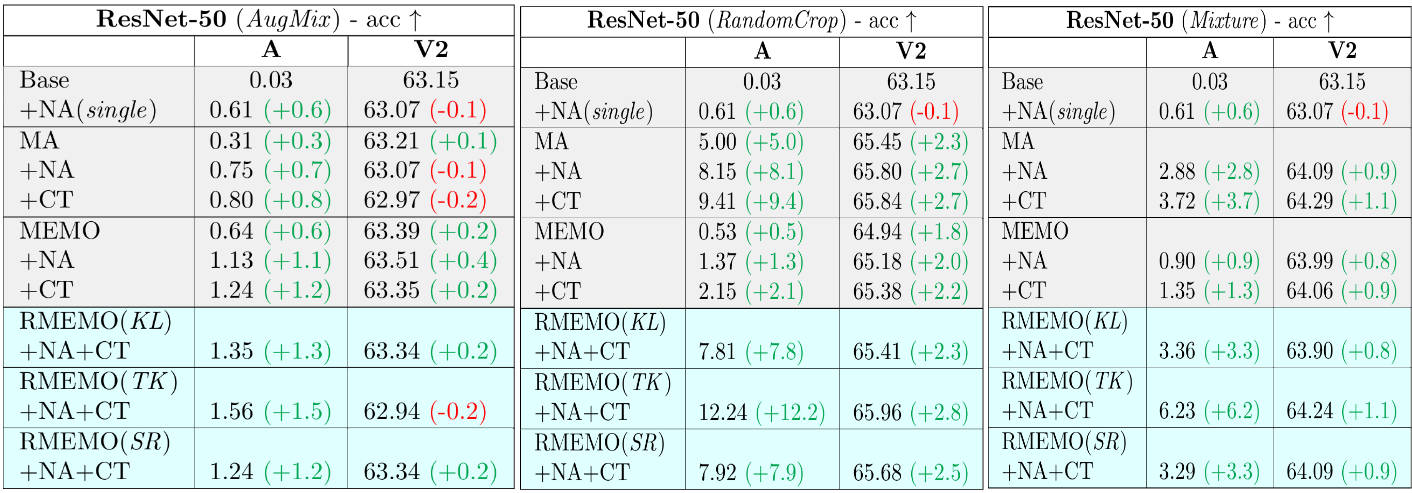

Here you can see the result of RMEMO w.r.t. other techniques on three different types of augmentations. For all experiments N=64, K=8, ct=0.5 and the adaptation factor prior_N=16, the model is optimized via SGD with lr=0.00025 as done by [Zhang et al. (2021)](https://arxiv.org/abs/2110.09506).

You can see that RMEMO especially with SR heuristic performed almost in every experiment at least as good as MEMO in all datasets.

As already introduced MA seems to be a strong baseline for our datasets but should fell short w.r.t MEMO when some corruption or explicit distribution shift appears (see [Zhang et al. (2021)](https://arxiv.org/abs/2110.09506)). Whenever good information is proposed by the model in the form of model predictions of augmented images RMEMO easily catch up with MA inference boosing performance in these scenarios but still remaining robust when MA is outperformeed by MEMO. I expect these findings to easily convert to other datasets where this phenomena should be accentuated (e.g. ImageNet-C, ImageNet-R).

We can also see that TK heuristic really outperform KL and SR when good informative augmented images are fed into the model but to not being robust when this assumption is not respected, remarking the value of confidence selection strategies but showing as expected that if the model is wrongly confident performances can drastically drops.

Finally, we can clearly see that performances of all methods are direcly correlated by how much the augmentation procedure is able to give good, informative augmented samples under the modelled distribution. For example we can assume that real world image datasets (e.g. ImageNet) contains naturally images with objects at different location and scale making the pre-trained model aware of such image distribution changes (in this case CNNs are translation invariant by construction), consequently Random Crops are more informative for this model than the other augmentations procedures. Notice this could not be the case for models trained with smaller datasets or on other distributions (think again about medical images), in those case RMEMO can still give robust predictions.

*Note*:

The augmentation procedure is stochastic and it is not controlled in the experiments so small fluctuations in the results should be taken into account even though an high amount augmentations are being sampled.

### Biased RMEMO

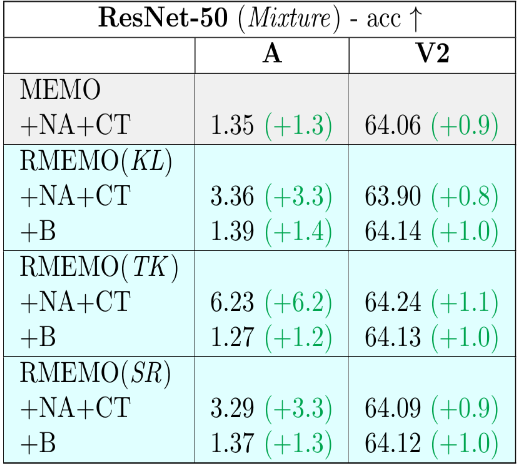

To obtain more guaratees and robustness Biased RMEMO should be able to give them. In these experiments the bias coefficient ($\textrm{bc}$) is set as the orignal accuracy of ResNet-50 reported on ImageNet test set so 0.76.

Biased RMEMO maintain the original accuracy and seems to be able to slightly improve performances even if little influence is given by the marginal probability prediction of augmented sample to the final prediction.

Notice also that this estimate is wrong for both ImageNet-A and ImageNet-V2 because real test accuracies are our baselines so (0.03 and 0.63), the ImageNet-A not Biased results can be seen as an extreme ablation case where we guess exactly that the model is not able to make any right prediction for images in the dataset, in this case we let the prediction be done fully by the marginal probability grasping the most out of model knowledge and getting way better results.

It will be interesting to experiment more with this technique and be able to comment more results.

## Ablations

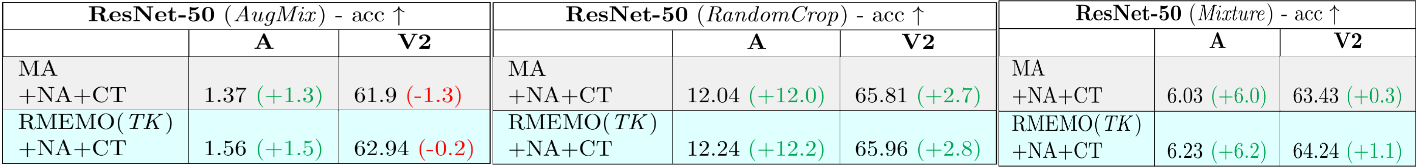

Do we really need RMEMO(TK) when we simply predict via MA with the same top K images?

In this study top 8 images are selected before and after the entropy minimization step, the results show the effectiveness of entropy minimization when we have less and more sparse information given by the model. However the effect of optimization is less remarked when the model is fed with better augmented images.

Even when no corruptions or distribution shift are assumed the model predictions get better after being optimized, showing the effectiveness of entropy minimization as self-supervise TTA objective at making the model more robust.

## Additional results

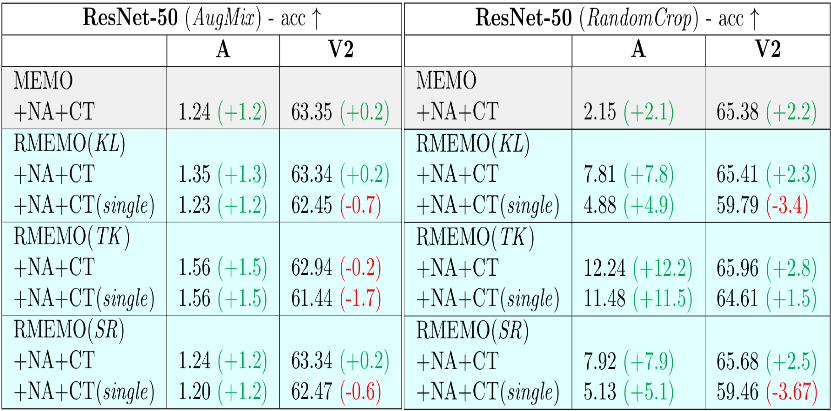

In this table we can observe how RMEMO behave when we fed only a single image (so K=1) selected by our heuristic. It is easy to see that performances can drop by an high margin even when with Random Crops.

This observed phenomena gave the idea to implement the Biased version as it is more stable when we have a limited amount of resources, the variance in the results is compensated by predicting aggregating information with a more stable test sample.

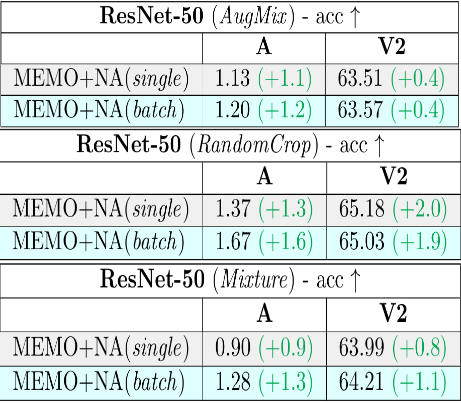

As final results, you can have a look above at the difference between keeping the computed statistics in the 1st forward pass to inference in the 2nd one, instead of computing them again. We can observe an improvement in almost all scenarios.

*Note*:

I decided to not use batch statistics in other experiment to isolate the effect of my proposal and do not overload with simultaneous changes the TTIA technique. In this way I hope to have shown a fair comparison between methods.

# Discussion

The main lesson that we can learn by the experiments is that in the TTIA settings, as expected, knowing under which enviroment the model will be tested and how to produce meaningful and informative samples gives us the possibility to squeeze the most out of the model knowledge and increase at much as possible the performaces. However, when we face an uncertain scenario it is hard to select an ad-hoc technique.

Inferencing from more samples averaging results can reduce variance and get the best out of a pre-trained model, answering the questions "How can we measure the goodness and trustability of model prediction?" and "How can we use the informative samples to guide the inference technique?" could lead to better results, nevertheless if the model is not able to output meaningful informations TTIA could be a limited choice to achieve better results.

A big drawback of MEMO and especially RMEMO it is the necessity to set of a lot of hyperparameters manually, I think it is possible to implement techniques that are able to automatically set/select some of them measuring the amount of information expressed by the model when tested on different enviroments.

# Conclusions

In this project a more robust version of MEMO (RMEMO) has been proposed and tested under different settings. In order to select images for final inference three heuristics (KL, TK and SR) have been tried out, and a conceptually different approach of TTIA took some space in the experiments (Biased RMEMO).

The approaches have shown capabilities to improve performance when the pre-trained model is able to give important predictive information also on augmented samples and still being robust in different experimental settings with little computational overhead. I expect to easily see these results translate in settings where explicit corruptions or distribution shift are observed, where MEMO has already demostrate its effectiveness and obtained better results than other methods.